### Analyze the full S&P 10K NLP dataset

### Load the required libraries

In [1]:
import pandas as pd
import numpy as np
import math
import pickle
import matplotlib.pyplot as plt
import matplotlib.style as style

!pip install yfinance
import yfinance as yf
import datetime as dt

import requests
!conda install -c anaconda beautifulsoup4 -y
from bs4 import BeautifulSoup

  Stored in directory: /home/jupyterlab/.cache/pip/wheels/fe/a0/79/b73d4a0c535b421b88fc7b393936b371fabbfeaf979eca4050
  Stored in directory: /home/jupyterlab/.cache/pip/wheels/37/fa/73/d492849e319038eb4d986f5152e4b19ffb1bc0639da84d2677
Successfully built yfinance multitasking
Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - beautifulsoup4


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    beautifulsoup4-4.9.3       |     pyhb0f4dca_0          87 KB  anaconda
    ca-certificates-2020.10.14 |                0         128 KB  anaconda
    certifi-2020.6.20          |           py36_0         160 KB  anaconda
    soupsieve-2.0.1            |             py_0          33 KB  anaconda
    ------------------------------------------------------------
                                           Total:         4

### Load the NLP dataset

In [2]:
#Load the dataset that contains our historical pricing
file =  "filings_returns_nlp.p"
data = pickle.load( open( file, "rb" ) )
data['Word_chg'] = np.sign(data['Word_chg'] ) 
data = data.astype({"Report_Period":'str'})
print(data.head())

  Ticker     Company  GICS Sector         GICS Sub Industry Report_Period  \
0    MMM  3M Company  Industrials  Industrial Conglomerates          2019   
1    MMM  3M Company  Industrials  Industrial Conglomerates          2019   
2    MMM  3M Company  Industrials  Industrial Conglomerates          2019   
3    MMM  3M Company  Industrials  Industrial Conglomerates          2019   
4    MMM  3M Company  Industrials  Industrial Conglomerates          2019   

  Filing_Date   Cos_Sim  Word_chg Trade_Date Adj_Close  
0  2020-02-06  0.932309      -1.0 2020-02-06   154.621  
1  2020-02-06  0.932309      -1.0 2020-02-07   151.954  
2  2020-02-06  0.932309      -1.0 2020-02-10    152.02  
3  2020-02-06  0.932309      -1.0 2020-02-11   154.203  
4  2020-02-06  0.932309      -1.0 2020-02-12   155.485  


In [3]:
print(data.shape)

"""
The dataset includes firms that either restated or adjusted filings multiple years
after the report period.  Those records should be removed from the analysis here.
"""

date_period = data['Trade_Date'].dt.year -1
print(date_period.dtype)
data['Report_Period'] = data['Report_Period'].astype(float) 
data.drop(data[data['Report_Period'] < date_period].index, inplace = True)
print(data.shape)
print(data.head())

(539599, 10)
float64
(416956, 10)
  Ticker     Company  GICS Sector         GICS Sub Industry  Report_Period  \
0    MMM  3M Company  Industrials  Industrial Conglomerates         2019.0   
1    MMM  3M Company  Industrials  Industrial Conglomerates         2019.0   
2    MMM  3M Company  Industrials  Industrial Conglomerates         2019.0   
3    MMM  3M Company  Industrials  Industrial Conglomerates         2019.0   
4    MMM  3M Company  Industrials  Industrial Conglomerates         2019.0   

  Filing_Date   Cos_Sim  Word_chg Trade_Date Adj_Close  
0  2020-02-06  0.932309      -1.0 2020-02-06   154.621  
1  2020-02-06  0.932309      -1.0 2020-02-07   151.954  
2  2020-02-06  0.932309      -1.0 2020-02-10    152.02  
3  2020-02-06  0.932309      -1.0 2020-02-11   154.203  
4  2020-02-06  0.932309      -1.0 2020-02-12   155.485  


### Calculate KPIs

In [4]:
def get_return(DF, years):
    """
    Returns cumulative portfolio return for each periodic series
    by calculating the respective post-filing window within a filtered dataset
    """
    df = DF.copy()
    daily_ret = [0]
    for yr in years:
        df = DF.query("Report_Period==@yr")
        year_df = df.copy()
        df = df.pivot(index=["Trade_Date"], columns=["Ticker"], values=["Adj_Close"])
#         print(df.head())
        df = df.pct_change()
        tickers = year_df['Ticker'].unique()
        for tick in tickers:
            df1 = df.xs(tick, level='Ticker', axis=1)
            trades = year_df.query("Ticker==@tick")['Trade_Date'].iloc[0:]
            df1 = df1.loc[trades]
            df1 =  df1.fillna(0)
            for m in range(len(df1)):
                daily_ret.append(df1.iloc[m:].mean())
    daily_ret_df = pd.DataFrame(np.array(daily_ret, dtype=object),columns=["daily_returns"])
    return daily_ret_df

In [5]:
def CAGR(DF):
    df = DF.copy()
    if len(df)>12: #annualize if greater than 12 periods
        n = len(df)/ 252
    else:
        n= len(df)
    df["cum_return"] = (1 + df).cumprod()
    CAGR = df["cum_return"].tolist()[-1]**(1/n) - 1
    return CAGR

In [6]:
#Calculate investment sharpe ratio

def volatility(DF):
    "function to calculate annualized volatility of a trading strategy"
    df = DF.copy()
    vol = df["daily_returns"].std() * np.sqrt(252)
    return vol

def sharpe(DF,rf):
    "function to calculate sharpe ratio ; rf is the risk free rate"
    df = DF.copy()
    sr = (CAGR(df) - rf) / volatility(df)
    return sr

In [ ]:
#Testing data count

pd.set_option('display.max_rows', None)

term = 252
# year  = ['2015', '2016', '2017', '2018', '2019']
year  = ['2018']
daily = data.query("Report_Period==@year")
print(daily.head())
tkr_by_year = daily.groupby(['Ticker']).head(term)
# print(tkr_by_year.Ticker.nunique())
# print(tkr_by_year.shape)
tkr_by_year.groupby(["Ticker"]).agg({"Trade_Date":"count"})
# df = get_return(tkr_by_year, year)


## Backtesting

Calculate the Holding Period Returns over 1 month incremental time horizons to interpret the timing 
of when 10k risk updates gets impounded into stock prices.

Build the datasets given high document variability(low cosine similiarity) vs low document variablity (high cosine similarity)

### Analyze the monthly return data

In [ ]:
#Determine which monthly duration from report date yields the greatest impact on prices

returns_dict =  {'Months':[],'Strategy':[],'Trades':[],'Ann_Returns':[],'Volatility':[]}

# print(df1.shape)
for term in range(1,210,30):
    print(term)
    year  = ['2015', '2016', '2017', '2018', '2019']
#     year  = ['2015']
    daily = data.query("Report_Period==@year")
    tkr_by_year = daily.groupby(['Ticker']).head(term)
    #view portfolio returns by trading days within window per year for the basket
#   
    #bottom quantile of CSim due to an increase in neg word frequency
    shorts = tkr_by_year.loc[(tkr_by_year['Cos_Sim'] < tkr_by_year['Cos_Sim'].quantile(0.25)) &
                    (tkr_by_year['Word_chg'] == 1)] 
    #top quantile of CSim due to a small change in neg word frequency
    longs = tkr_by_year.loc[(tkr_by_year['Cos_Sim'] > tkr_by_year['Cos_Sim'].quantile(0.75)) &
                    (tkr_by_year['Word_chg'] == -1)] 

    change_ret = CAGR(get_return(shorts,year))[0]*100
    print(change_ret)
    change_trades = shorts['Ticker'].nunique()
    change_vol = volatility(get_return(shorts,year))*100
    returns_dict['Volatility'].append(change_vol)
    returns_dict['Months'].append(math.floor((term/30)))
    returns_dict['Strategy'].append("Changers")
    returns_dict['Ann_Returns'].append(change_ret)
    returns_dict['Trades'].append(change_trades)

    nonchange_ret = CAGR(get_return(longs, year))[0]*100
    print(nonchange_ret)
    nonchange_trades = longs['Ticker'].nunique()
    nonchange_vol = volatility(get_return(longs, year))*100
    returns_dict['Volatility'].append(nonchange_vol)
    returns_dict['Months'].append(math.floor((term/30)))
    returns_dict['Strategy'].append("Non-changers")
    returns_dict['Ann_Returns'].append(nonchange_ret)
    returns_dict['Trades'].append(nonchange_trades)
    
    ls_port_alpha_ret = nonchange_ret - change_ret
    ls_port_alpha_count = nonchange_trades + change_trades
    ls__port_alpha_vol = change_vol - nonchange_vol
    returns_dict['Volatility'].append(ls__port_alpha_vol)
    returns_dict['Months'].append(math.floor((term/30)))
    returns_dict['Strategy'].append("spread")
    returns_dict['Ann_Returns'].append(ls_port_alpha_ret)
    returns_dict['Trades'].append(ls_port_alpha_count)
    
return_comp = pd.DataFrame(returns_dict)

Which stocks not only have the highest dissimilarity between reporting years but also had the greatest increase in negative word embeddings, portending an increase in volatility and/or positive alpha through a basket of long options in change-term filing firms and short options in non-change sentiment firms.

In [9]:
return_comp.style.format({ 
                          "Ann_Returns": "{:20,.02f}%",
                        "Volatility": "{:20,.02f}%",
                          "Months": "{:20,.0f}mos"})\
                    .background_gradient(cmap='viridis')\
                    .set_caption('Long/Short Portfolio Cumulative Annualized Returns Over a 6mo Trading Window') \
                    .hide_index()

Months,Strategy,Trades,Ann_Returns,Volatility
0mos,Changers,57,0.00%,0.00%
0mos,Non-changers,43,0.00%,0.00%
0mos,spread,100,0.00%,0.00%
1mos,Changers,62,-62.64%,29.16%
1mos,Non-changers,44,32.17%,27.91%
1mos,spread,106,94.82%,1.25%
2mos,Changers,62,51.95%,13.72%
2mos,Non-changers,44,86.14%,12.00%
2mos,spread,106,34.19%,1.72%
3mos,Changers,63,46.09%,9.93%


### Plotting the annualized returns curves for each term period

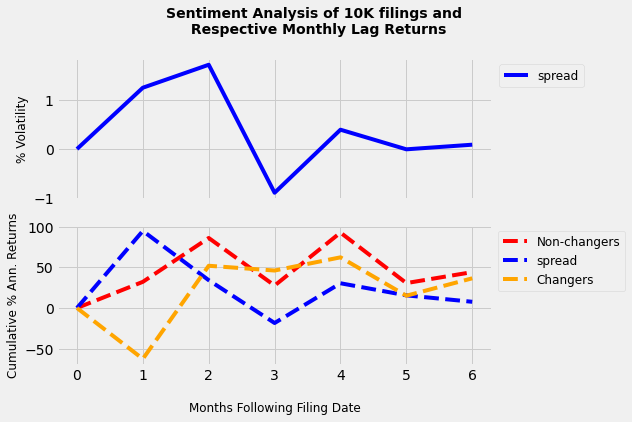

In [10]:
style.use('fivethirtyeight')

fig, (ax2, ax) = plt.subplots(2, figsize=(9,6),sharex=True)

ax.set_prop_cycle(color=['red', 'blue', 'orange'])
strat = ['Non-changers','spread','Changers']
for type in strat:
    ax.plot(return_comp[return_comp.Strategy==type].Months,
            return_comp[return_comp.Strategy==type].Ann_Returns,
            label=type, linestyle=('--'))
fig.suptitle("Sentiment Analysis of 10K filings and \n Respective Monthly Lag Returns",
             wrap=True, fontsize=14, fontweight='bold')

ax.set_xlabel("\nMonths Following Filing Date", fontsize= 12)
             
ax.set_ylabel("Cumulative % Ann. Returns", fontsize= 12)
plt.legend(labels=strat,fontsize= 12, loc='best',bbox_to_anchor=(1, 1))

vol = return_comp[return_comp.Strategy=='spread'].Volatility
spd = return_comp[return_comp.Strategy=='spread'].Months
ax2.plot(spd,vol, label="spread", color = 'blue')
ax2.legend(fontsize= 12, loc='best',bbox_to_anchor=(1.225, 1))
ax2.set_ylabel("% Volatility", fontsize= 12)

plt.tight_layout()

plt.savefig("return_curve_by_month.png", dpi = 75);

As we can see from taking a closer look at the above curves, we can potentially draw a couple central conclusions:

1. The best performing months occurred within the first two months and the 5th month interval post 10-K filing.  Given that the spread between the negatively changing sentiment firms('Changers') and the non-changing sentiment firms is at its greatest.
2. The volatility premium exhibited by the Changers, the spread vol as a proxy, remained positive or flat through the focus period.
3. The broader market environment was likely favorable overall as both strategies exhibited positive returns after the first month's post filing.

In [55]:
#Determine which monthly duration from report date yields the greatest impact on prices

returns_dict =  {'Days':[],'Strategy':[],'Trades':[],'Ann_Returns':[]}

# print(df1.shape)
for term in range(1,61,2):
    print(term)
    year  = ['2015', '2016', '2017', '2018', '2019']
#     year  = ['2015']
    daily = data.query("Report_Period==@year")
    tkr_by_year = daily.groupby(['Ticker']).head(term)
    #view portfolio returns by trading days within window per year for the basket
#   
    #bottom quantile of CSim due to an increase in neg word frequency
    shorts = tkr_by_year.loc[(tkr_by_year['Cos_Sim'] < tkr_by_year['Cos_Sim'].quantile(0.25)) &
                    (tkr_by_year['Word_chg'] == 1)] 
    #top quantile of CSim due to a small change in neg word frequency
    longs = tkr_by_year.loc[(tkr_by_year['Cos_Sim'] > tkr_by_year['Cos_Sim'].quantile(0.75)) &
                    (tkr_by_year['Word_chg'] == -1)] 

    change_ret = CAGR(get_return(shorts,year))[0]*100
    print(change_ret)
    change_trades = shorts['Ticker'].nunique()
#     change_vol = volatility(get_return(shorts,year))*100
#     returns_dict['Volatility'].append(change_vol)
    returns_dict['Days'].append(term)
    returns_dict['Strategy'].append("Changers")
    returns_dict['Ann_Returns'].append(change_ret)
    returns_dict['Trades'].append(change_trades)

    nonchange_ret = CAGR(get_return(longs, year))[0]*100
    print(nonchange_ret)
    nonchange_trades = longs['Ticker'].nunique()
#     nonchange_vol = volatility(get_return(longs, year))*100
#     returns_dict['Volatility'].append(nonchange_vol)
    returns_dict['Days'].append(term)
    returns_dict['Strategy'].append("Non-changers")
    returns_dict['Ann_Returns'].append(nonchange_ret)
    returns_dict['Trades'].append(nonchange_trades)
    
    ls_port_alpha_ret = nonchange_ret - change_ret
    ls_port_alpha_count = nonchange_trades + change_trades
#     ls__port_alpha_vol = change_vol - nonchange_vol
#     returns_dict['Volatility'].append(ls__port_alpha_vol)
    returns_dict['Days'].append(term)
    returns_dict['Strategy'].append("spread")
    returns_dict['Ann_Returns'].append(ls_port_alpha_ret)
    returns_dict['Trades'].append(ls_port_alpha_count)
    
daily_return_df = pd.DataFrame(returns_dict)

1
0.0
0.0
3
-80.5711174272916
-58.665789983086334
5
-88.8554248088608
-80.86256037296381
7
-95.8473047782106
-98.12524979090159
9
-84.61787163621233
-93.37363294304681
11
-81.08011610146184
-80.94476986943052
13
-98.36299645786343
-94.43771361041546
15
-95.72650885628353
-93.45507275613552
17
-97.25871808769888
-96.39990213591258
19
-96.42126747384741
-93.8736594769949
21
-97.37852114147043
-91.06623035924879
23
-95.56936200416756
-91.64448758456594
25
-84.01174820334874
-85.47544305321355
27
-74.1062362732573
-36.885342801538144
29
-72.16237115357391
92.92850195504403
31
-62.643659137099604
32.17237860717543
33
-48.650874742337535
4.949756249127546
35
59.23497424808004
64.33394271196127
37
96.95449767590756
139.91036290809126
39
42.67281203344373
149.14407532531294
41
25.95323001763161
150.9853232650756
43
85.81169930616062
180.47644962412326
45
108.41638780569242
105.47041098149914
47
121.69475110752059
134.4425567018535
49
148.7936819245358
101.40392086248569
51
144.3222471031557
10

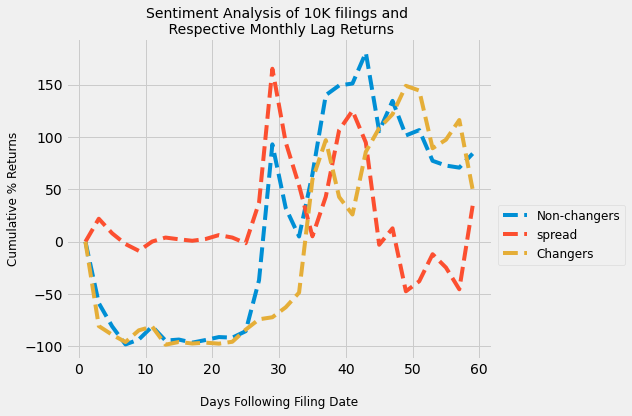

In [56]:
style.use('fivethirtyeight')

fig,ax = plt.subplots(figsize=(9,6))

strategy = ['Non-changers','spread','Changers']
for type in strategy:
    ax.plot(daily_return_df[daily_return_df.Strategy==type].Days,
            daily_return_df[daily_return_df.Strategy==type].Ann_Returns,
            label=type, linestyle=('--'))
ax.set_title("Sentiment Analysis of 10K filings and \n Respective Monthly Lag Returns",
             wrap=True, fontsize=14)

ax.set_xlabel("\nDays Following Filing Date", fontsize= 12)
             
ax.set_ylabel("Cumulative % Returns", fontsize= 12)
plt.legend(labels=strategy,fontsize= 12, loc='best',bbox_to_anchor=(1, 0.5))

plt.tight_layout()

plt.savefig("daily_return_curve.png", dpi = 75);


Understanding the first two months of trends:

* First 20 days reflects initial impact from earnings/10K release.  
* The spread between these types of 10K filings is began to materialize closer to the end of the month with the non-changing firms outperforming. 
* After the initial peak in the spread at period 30 days post filing, the spread peaked again after 1 and 1/2 months.  In each case, the spread between both reporting firms was delayed before this distinction was impounded into stock prices.

### Review the data through the 4th month following the 10k filing

Strongest return profile of the post filing period

How did this trading strategy fair against the annualized S&P returns?

In [7]:
#Get S&P data for comparision returns

start="2015-01-01"
end="2020-12-31"
SPX = yf.download("^GSPC", start=start, end=end)
SPX.reset_index(inplace=True)
SPX['Year'] =SPX.Date.dt.to_period('Y').astype(str)
SPX["daily_returns"] = SPX["Adj Close"].pct_change().fillna(0)

SPX.head()

[*********************100%***********************]  1 of 1 completed


,Date,Open,High,Low,Close,Adj Close,Volume,Year,daily_returns
0,2015-01-02,2058.899902,2072.360107,2046.040039,2058.199951,2058.199951,2708700000,2015,0.000000
1,2015-01-05,2054.439941,2054.439941,2017.339966,2020.579956,2020.579956,3799120000,2015,-0.018278
2,2015-01-06,2022.150024,2030.250000,1992.439941,2002.609985,2002.609985,4460110000,2015,-0.008893
3,2015-01-07,2005.550049,2029.609985,2005.550049,2025.900024,2025.900024,3805480000,2015,0.011630
4,2015-01-08,2030.609985,2064.080078,2030.609985,2062.139893,2062.139893,3934010000,2015,0.017888


### Reviewing the data through month 4 following 10k filing by year

In [8]:
#Reviewing the data through month 4 post 10k filing by year

comps_returns_dict = {'Year':[],
                    'Period':[],
                    'Strategy':[],
                    'Trades':[],
                    'Ann_Returns':[],
                    'Sharpe':[]
                   }

#view portfolio returns by trading days within window per year for the basket
term = 120  #(roughly 4 mos post filing)
daily = data.groupby(['Report_Period', 'Ticker']).head(term)

years = ['2015', '2016', '2017', '2018', '2019']

for yr in years:
    ty = int(yr)+1  #trading period occurs 1year following report year
    print(f"Calculating Trading Year: {ty}") 
    year = [yr]
    ty = str(ty)
    SPX_term = SPX.query("Year==@ty")
    tkr_by_year = daily.query("Report_Period==@year")
    #bottom quantile of CSim due to an increase in neg word frequency
    shorts = tkr_by_year.loc[(tkr_by_year['Cos_Sim'] < tkr_by_year['Cos_Sim'].quantile(0.25)) &
                    (tkr_by_year['Word_chg'] == 1)] 
    #top quantile of CSim due to a small change in neg word frequency
    longs = tkr_by_year.loc[(tkr_by_year['Cos_Sim'] > tkr_by_year['Cos_Sim'].quantile(0.75)) &
                    (tkr_by_year['Word_chg'] == -1)] 

#     CHANGE company returns
    change_ret = CAGR(get_return(shorts,year))[0]*100
    change_sharpe = sharpe(get_return(shorts, year),.025)[0]
    # change_mdd = max_dd(get_return(shorts, term, year))
    print(change_ret)
    change_alpha_trades = shorts['Ticker'].nunique()
    comps_returns_dict['Period'].append(term)
    comps_returns_dict['Strategy'].append("Changers")
    comps_returns_dict['Trades'].append(change_alpha_trades)
    comps_returns_dict['Ann_Returns'].append(change_ret)
    comps_returns_dict['Sharpe'].append(change_sharpe)
    comps_returns_dict['Year'].append(ty)

#     NON-CHANGE company returns
    nonchange_ret = CAGR(get_return(longs,  year))[0]*100
    nonchange_sharpe = sharpe(get_return(longs, year),.025)[0]
    # nonchange_mdd = max_dd(get_return(longs, term, year))
    print(nonchange_ret)
    nonchange_trades = longs['Ticker'].nunique()
    comps_returns_dict['Period'].append(term)
    comps_returns_dict['Strategy'].append("Non-changers")
    comps_returns_dict['Trades'].append(nonchange_trades)
    comps_returns_dict['Ann_Returns'].append(nonchange_ret)
    comps_returns_dict['Sharpe'].append(nonchange_sharpe)
    comps_returns_dict['Year'].append(ty)
    
#     LONG-SHORT CHANGE/NON-CHANGE company returns
    ls_port_alpha_ret = nonchange_ret - change_ret
    ls_port_alpha_count = nonchange_trades + change_alpha_trades
    comps_returns_dict['Period'].append(term)
    comps_returns_dict['Strategy'].append("spread")
    comps_returns_dict['Trades'].append(ls_port_alpha_count)
    comps_returns_dict['Ann_Returns'].append(ls_port_alpha_ret)
    comps_returns_dict['Sharpe'].append(nonchange_sharpe - change_sharpe)
    comps_returns_dict['Year'].append(ty)
    
#     Add SPX returns
    sp_term = len(SPX_term)
    spx_ret = CAGR(SPX_term['daily_returns'])*100
    spx_sharpe = sharpe(SPX_term[['daily_returns']],.025)
    print(spx_ret)
    spx_trades = 1
    comps_returns_dict['Period'].append(sp_term)
    comps_returns_dict['Strategy'].append("S&P 500")
    comps_returns_dict['Trades'].append(spx_trades)
    comps_returns_dict['Ann_Returns'].append(spx_ret)
    comps_returns_dict['Sharpe'].append(spx_sharpe)
    comps_returns_dict['Year'].append(ty)

    comps_returns = pd.DataFrame(comps_returns_dict)

Calculating Trading Year: 2016
17.18154508029739
27.14901924290578
9.535022667283698
Calculating Trading Year: 2017
1.3383376574771733
9.284089927133564
19.504434441120246
Calculating Trading Year: 2018
12.976757927602645
8.737905278949176
-6.26131480156038
Calculating Trading Year: 2019
-8.809844190298788
-5.040453763140329
28.87807022515858
Calculating Trading Year: 2020
64.37399189186787
87.80213943798199
15.515138920637629


In [9]:
comps_returns

,Year,Period,Strategy,Trades,Ann_Returns,Sharpe
0,2016,120,Changers,43,17.181545,2.920124
1,2016,120,Non-changers,40,27.149019,5.942674
2,2016,120,spread,83,9.967474,3.022549
3,2016,252,S&P 500,1,9.535023,0.537231
4,2017,120,Changers,46,1.338338,-0.229076
5,2017,120,Non-changers,36,9.284090,1.694882
6,2017,120,spread,82,7.945752,1.923958
7,2017,251,S&P 500,1,19.504434,2.543418
8,2018,120,Changers,48,12.976758,1.565400
9,2018,120,Non-changers,45,8.737905,1.291693


### Create a visual to better understand the strategy compared to the S&P500 return

In [10]:
#pvot dataasets for returns and sharpe ratios 
comps = comps_returns.copy()

data_piv = comps.pivot_table(values='Ann_Returns', index=comps.Year, columns='Strategy', aggfunc='first')
data_shp_piv = comps.pivot_table(values='Sharpe', index=comps.Year, columns='Strategy', aggfunc='first')

In [11]:
pd.set_option('display.max_columns', None)
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))

#Annualized Return table
printmd("\n**Annualized Return By Strategy**\n")
print("*S&P return does not include dividends")
print("**spread represents long Non-changers/short Changers \n")
print(data_piv.head())

#Sharpe table
print()
printmd("\n**Annualized Sharpe By Strategy**\n")
print("*S&P return does not include dividends")
print("**spread represents long Non-changers/short Changers \n")
print(data_shp_piv.head())

#Average comps
spd = data_piv.spread/100  #adjust spread return
sp5 = data_piv['S&P 500']/100  #adjust s&p return
n = len(data_piv)
spread_cagr = round((np.prod((1+spd)**(1/n))-1)*100,2)
sp5_cagr = round((np.prod((1+sp5)**(1/n))-1)*100,2)
spread_sharpe_avg = round(data_shp_piv.spread.mean(),2)
sp5_sharpe_avg = round(data_shp_piv['S&P 500'].mean(),2)
print()
print()
mos = round(term/30,0)
printmd(f"\n**Annualized Average Comps By Strategy @ {mos} mos** (2016-2020)\n")
print(f"Long/Short portfolio (5yr CAGR): {round(spread_cagr,2)}")
print(f"Long/Short portfolio (average Sharpe): {spread_sharpe_avg}")
print(f"S&P500 portfolio (5yr CAGR): {round(sp5_cagr,2)}")
print(f"S&P500 portfolio (average Sharpe): {sp5_sharpe_avg}")


**Annualized Return By Strategy**


*S&P return does not include dividends
**spread represents long Non-changers/short Changers 

Strategy   Changers  Non-changers    S&P 500     spread
Year                                                   
2016      17.181545     27.149019   9.535023   9.967474
2017       1.338338      9.284090  19.504434   7.945752
2018      12.976758      8.737905  -6.261315  -4.238853
2019      -8.809844     -5.040454  28.878070   3.769390
2020      64.373992     87.802139  15.515139  23.428148




**Annualized Sharpe By Strategy**


*S&P return does not include dividends
**spread represents long Non-changers/short Changers 

Strategy  Changers  Non-changers   S&P 500    spread
Year                                                
2016      2.920124      5.942674  0.537231  3.022549
2017     -0.229076      1.694882  2.543418  1.923958
2018      1.565400      1.291693 -0.513813 -0.273707
2019     -1.467814     -1.216854  2.114973  0.250960
2020      8.002338     10.654559  0.377306  2.652222





**Annualized Average Comps By Strategy @ 4.0 mos** (2016-2020)


Long/Short portfolio (5yr CAGR): 7.8
Long/Short portfolio (average Sharpe): 1.52
S&P500 portfolio (5yr CAGR): 12.81
S&P500 portfolio (average Sharpe): 1.01


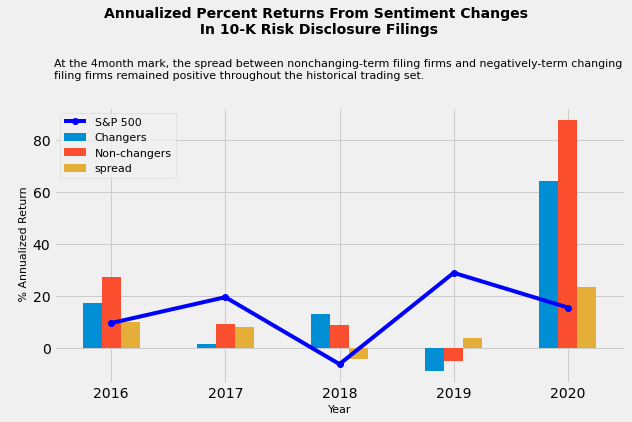

In [31]:
style.use('fivethirtyeight')
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})

colors_list = [['#5cb85c','#5bc0de','#d9534f']]


ax = data_piv[['Changers', 'Non-changers','spread' ]].plot(kind='bar',
              width = 0.5,
              edgecolor=None, 
             xlabel="", figsize=(9,6),)
data_piv['S&P 500'].plot(kind='line',color='b',linestyle='-', marker="o", ax=ax)


plt.ylabel("\n % Annualized Return",fontsize= 11)
plt.xlabel("Year",fontsize= 11)

plt.suptitle("Annualized Percent Returns From Sentiment Changes\n In 10-K Risk Disclosure Filings",
             fontweight='bold',fontsize=14)

plt.legend(fontsize= 11, loc='upper left')

plt.title("At the 4month mark, the spread between nonchanging-term filing firms and negatively-term changing\n" 
          "filing firms remained positive throughout the historical trading set.\n\n",
          loc='left',fontsize= 11)

plt.savefig("yearly_barchart_comps.png", dpi = 75)
plt.tight_layout()
plt.show()


One important note on the backdrop of this period of study from 2015 through 2020, the broader market experienced only a single down year in 2018, each of the other years returned nearly double digits.  Despite the market lifting most stocks during the period, there was a predictable pattern of the non-changing 10-K firms outperforming those firms that negatively changed their financials the most.



**Possible implications for creating the following portfolios:**
1. Long/Short event driven
2. Dispersion portfolios
3. Long/Short ATM straddle portfolios

### Reviewing the 4th month's trend for each stock

In [ ]:
#print the 4mos trend to a dataframe to see where stocks react following its respective report date

pd.set_option('display.max_columns', None)
daily_returns_dict =  {'Term':[],'Ticker':[],'Sector':[],'Ann_Returns':[]}

# print(df1.shape)
term = 120
    #view portfolio returns by trading days within window per year for the basket
daily = data.groupby(['Ticker']).head(term)
    
# year  = ['2015', '2016', '2017', '2018', '2019']
    
year  = ['2019']
tkr_by_year = daily[daily.Report_Period.isin(year)]
tickers = tkr_by_year['Ticker'].unique()
for x,tick in enumerate(tickers):
    print(f"Calculating ticker {tick}...")
    tkr_df = tkr_by_year.query("Ticker==@tick")
    if (tick=='ADP') | (tick=='BR') | (tick=='BF.B')| (tick=='CPB') | (tick=='CAH'):
        continue
    change_ret = CAGR(get_return(tkr_df, year))[0]*100
    change_sector = tkr_df['GICS Sector'].iloc[x]
    print(change_sector)
    daily_returns_dict['Term'].append(term)
    daily_returns_dict['Ticker'].append(tick)
    daily_returns_dict['Sector'].append(change_sector)
    daily_returns_dict['Ann_Returns'].append(change_ret)

daily_return_comp = pd.DataFrame(daily_returns_dict)


In [65]:
#The five month window reflected the greatest premium between this strategy of applying NLP negative term frequency analysis

sector_returns_dict =  {'Sector':[],'Strategy':[],'Ann_Returns':[],'Trades':[] }
year  = ['2015', '2016', '2017', '2018', '2019']
# year  = ['2019']
term = 120
daily = data.groupby(['Report_Period','Ticker']).head(term)
tkr_by_year = daily[daily.Report_Period.isin(year)]
for sector in tkr_by_year['GICS Sector'].unique():
    print(sector)
    sectors = tkr_by_year[tkr_by_year['GICS Sector'] == sector]
    
    changers = sectors.loc[(sectors['Cos_Sim'] < sectors['Cos_Sim'].quantile(0.25)) &
                    (sectors['Word_chg'] == 1)] #bottom quantile of CSim due to an increase in neg word frequency
    
    nonchangers = sectors.loc[(sectors['Cos_Sim'] > sectors['Cos_Sim'].quantile(0.75)) &
                    (sectors['Word_chg'] == -1)] #top quantile of CSim due to a small change in neg word frequency
    
    change_data = CAGR(get_return(changers, year))[0]*100 #review the dispersion in the sectors at the 60day time window
    change_trades = changers['Ticker'].nunique()
    print(f"Shorts: {changers['Ticker'].unique()}")
    sector_returns_dict['Sector'].append(sector)
    sector_returns_dict['Strategy'].append("Changers")
    sector_returns_dict['Ann_Returns'].append(change_data)
    sector_returns_dict['Trades'].append(change_trades)

    nonchange_data = CAGR(get_return(nonchangers, year))[0]*100 #review the dispersion in the sectors at the 60day time window
    nonchange_trades = nonchangers['Ticker'].nunique()
    print(f"Longs: {nonchangers['Ticker'].unique()}")
    sector_returns_dict['Sector'].append(sector)
    sector_returns_dict['Strategy'].append("Non-Changers")
    sector_returns_dict['Ann_Returns'].append(nonchange_data)
    sector_returns_dict['Trades'].append(nonchange_trades)
    
    ls_port_alpha_ret = nonchange_data - change_data
    ls_port_alpha_trades = nonchange_trades + change_trades
    sector_returns_dict['Sector'].append(sector)
    sector_returns_dict['Strategy'].append("spread")
    sector_returns_dict['Ann_Returns'].append(ls_port_alpha_ret)
    sector_returns_dict['Trades'].append(ls_port_alpha_trades)
    
sector_return_df = pd.DataFrame(sector_returns_dict)

Industrials
Shorts: ['ALK' 'ALLE' 'AAL' 'BA' 'DE' 'DAL' 'EMR' 'EFX' 'FAST' 'FDX' 'FLS' 'FBHS'
 'HII' 'IEX' 'J' 'LMT' 'MAS' 'NSC' 'NOC' 'PCAR' 'RTX' 'RHI' 'LUV' 'TDY'
 'TT' 'TDG' 'WM']
Longs: ['BA' 'CHRW' 'CTAS' 'CPRT' 'CSX' 'DE' 'ETN' 'FAST' 'GD' 'KSU' 'NSC' 'ODFL'
 'PCAR' 'PNR' 'SWK' 'TXT' 'UNP' 'UAL' 'VRSK']
Health Care
Shorts: ['ABT' 'ALXN' 'ABC' 'BDX' 'BIO' 'BSX' 'CAH' 'CTLT' 'COO' 'CVS' 'DHR' 'DVA'
 'XRAY' 'DXCM' 'GILD' 'IDXX' 'ILMN' 'INCY' 'MCK' 'MYL' 'PRGO' 'PFE' 'REGN'
 'RMD' 'TMO' 'UHS' 'VAR' 'ZBH' 'ZTS']
Longs: ['ABBV' 'A' 'BMY' 'CERN' 'COO' 'EW' 'ILMN' 'INCY' 'MCK' 'MDT' 'MRK' 'PKI'
 'DGX' 'TFX' 'UNH']
Information Technology
Shorts: ['AKAM' 'APH' 'ANSS' 'ADP' 'CDNS' 'CSCO' 'CTXS' 'GLW' 'FIS' 'FISV' 'FTNT'
 'IT' 'INTC' 'IPGP' 'KEYS' 'KLAC' 'LDOS' 'MA' 'MCHP' 'MU' 'NTAP' 'NLOK'
 'QCOM' 'STX' 'SWKS' 'SNPS' 'TEL' 'VRSN']
Longs: ['ACN' 'ADI' 'ANET' 'CDNS' 'FLT' 'HPQ' 'INTC' 'LDOS' 'MXIM' 'ORCL' 'CRM'
 'TEL' 'TYL' 'V' 'WDC' 'WU' 'XLNX' 'ZBRA']
Communication Services
Shorts: ['GOOG

In [66]:
sector_return_df.style.hide_index().format({ 
                          "Ann_Returns": "{:20,.0f}%", 
                          "Strategy": str.upper})\
                    .background_gradient(cmap='viridis')\
                    .set_caption('Sector Risk Adjusted Returns At 5-Month Trading Window')

Sector,Strategy,Ann_Returns,Trades
Industrials,CHANGERS,9%,27
Industrials,NON-CHANGERS,23%,19
Industrials,SPREAD,14%,46
Health Care,CHANGERS,34%,29
Health Care,NON-CHANGERS,41%,15
Health Care,SPREAD,7%,44
Information Technology,CHANGERS,44%,28
Information Technology,NON-CHANGERS,48%,18
Information Technology,SPREAD,3%,46
Communication Services,CHANGERS,83%,8


In [67]:
#create a bar chart with the sector comparisons

data_piv = sector_return_df.pivot_table(values='Ann_Returns', index=sector_return_df.Sector, columns='Strategy', aggfunc='first')
data_piv.sort_values("spread", ascending=False, inplace=True)

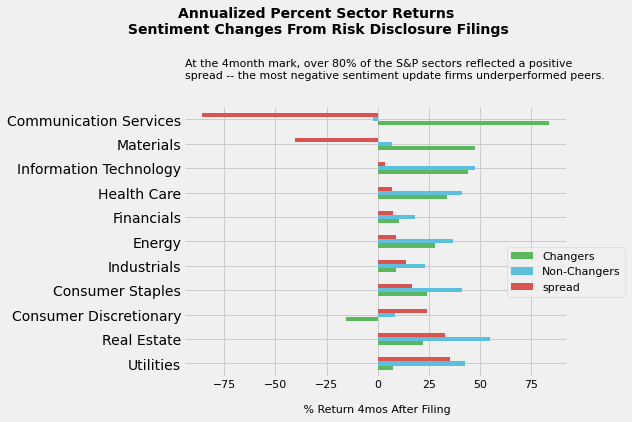

In [68]:
style.use('fivethirtyeight')
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})

colors_list = ['#5cb85c','#5bc0de','#d9534f']
data_piv.plot(kind='barh',figsize=(9,6),
              width = 0.5,
              color = colors_list,
              edgecolor=None,
             xlabel="")

plt.xlabel("\n % Return 4mos After Filing",fontsize= 11)

plt.suptitle("Annualized Percent Sector Returns\n Sentiment Changes From Risk Disclosure Filings", fontweight='bold',fontsize=14)

plt.legend(labels=data_piv.columns,fontsize= 11, loc='upper center',bbox_to_anchor=(1, 0.5))

plt.title("At the 4month mark, over 80% of the S&P sectors reflected a positive \n" 
          "spread -- the most negative sentiment update firms underperformed peers.\n\n",
          loc='left',fontsize= 11)

plt.xticks(fontsize=11)
for spine in plt.gca().spines.values():
    spine.set_visible(False)

plt.subplots_adjust(bottom=0.3)


plt.savefig("sector_barchart.png", dpi = 75)
plt.tight_layout()
plt.show()

In [69]:
#recreate charts for each sector showing the return curves over the trading window horizon


sector_returns_dict =  {'Months':[],'Sector':[],'Strategy':[],'Ann_Returns':[] }
year  = ['2015', '2016', '2017', '2018', '2019']
for term in range(1,210,30):
    print(term)
    #view portfolio returns by trading days within window per year for the basket
    daily = data.groupby(['Report_Period','Ticker']).head(term)
    tkr_by_year = daily[daily.Report_Period.isin(year)]
    for sector in tkr_by_year['GICS Sector'].unique():
        
        sectors = tkr_by_year[tkr_by_year['GICS Sector'] == sector]
        df1 = sectors.loc[(sectors['Cos_Sim'] < sectors['Cos_Sim'].quantile(0.25)) &
                    (sectors['Word_chg'] == 1)] #bottom quantile of CSim due to an increase in neg word frequency
        df2 = sectors.loc[(sectors['Cos_Sim'] > sectors['Cos_Sim'].quantile(0.75)) &
                    (sectors['Word_chg'] == -1)] #top quantile of CSim due to a small change in neg word frequency
    
#         market_sector = sectors['Adj_Close']
        sector_ret = CAGR(get_return(sectors, year))[0]*100 #review the dispersion in the sectors at the 60day time window
        sector_returns_dict['Months'].append(math.floor(term/30))
        sector_returns_dict['Sector'].append(sector)
        sector_returns_dict['Strategy'].append(sector)
        sector_returns_dict['Ann_Returns'].append(sector_ret)
#         sector_returns_dict['Sharpe'].append(market_alpha_shp)
        
        change_ret = CAGR(get_return(df1, year))[0]*100 #review the dispersion in the sectors at the 60day time window
        sector_returns_dict['Months'].append(math.floor(term/30))
        sector_returns_dict['Sector'].append(sector)
        sector_returns_dict['Strategy'].append("Changers")
        sector_returns_dict['Ann_Returns'].append(change_ret)
#         sector_returns_dict['Sharpe'].append(change_alpha_shp)
    
#         non_changers = df2['Return'] #all stocks in dataset, no filter

        nonchange_ret = CAGR(get_return(df2, year))[0]*100 #review the dispersion in the sectors at the 60day time window
        
        sector_returns_dict['Months'].append(math.floor(term/30))
        sector_returns_dict['Sector'].append(sector)
        sector_returns_dict['Strategy'].append("Non-changers")
        sector_returns_dict['Ann_Returns'].append(nonchange_ret)
#         sector_returns_dict['Sharpe'].append(nonchange_shp)
    
return_comp_windows = pd.DataFrame(sector_returns_dict)


1
31
61
91
121
151
181


In [70]:
returns4mos = return_comp_windows.query('Months == 4')
returns4mos.style.hide_index().format({ 
                          "Ann_Returns": "{:20,.0f}%",
                          "Months": "{:20,.0f}mos",
                          "Strategy": str.upper})\
                    .background_gradient(cmap='viridis')\
                    .set_caption('Sector Risk Adjusted Returns - First Few Sectors')

Months,Sector,Strategy,Ann_Returns
4mos,Industrials,INDUSTRIALS,27%
4mos,Industrials,CHANGERS,12%
4mos,Industrials,NON-CHANGERS,24%
4mos,Health Care,HEALTH CARE,29%
4mos,Health Care,CHANGERS,33%
4mos,Health Care,NON-CHANGERS,37%
4mos,Information Technology,INFORMATION TECHNOLOGY,38%
4mos,Information Technology,CHANGERS,41%
4mos,Information Technology,NON-CHANGERS,45%
4mos,Communication Services,COMMUNICATION SERVICES,21%


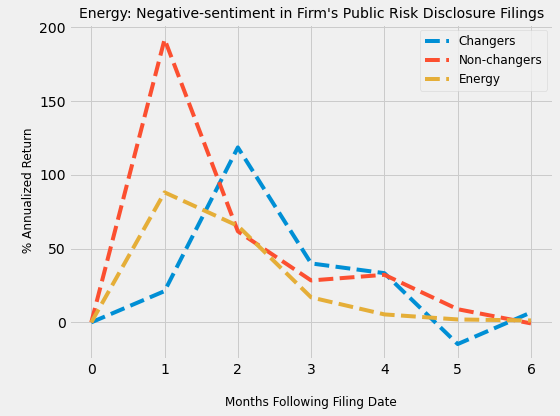

In [71]:
#Communication Services sector review

style.use('fivethirtyeight')

sector = 'Energy'
sectors = return_comp_windows[return_comp_windows['Sector'] == sector]  

fig,ax = plt.subplots(figsize=(8,6))

for type in ['Changers','Non-changers', sector]:
    ax.plot(sectors[sectors.Strategy==type].Months,
            sectors[sectors.Strategy==type].Ann_Returns,
            label=type, linestyle=('--'))

ax.set_xlabel("\nMonths Following Filing Date", fontsize= 12)
plt.ylabel("\n % Annualized Return",fontsize= 12)

ax.set_title("{}: Negative-sentiment in Firm's Public Risk Disclosure Filings".format(sector),fontsize=14)

ax.legend(loc='best',fontsize=12)

plt.show()

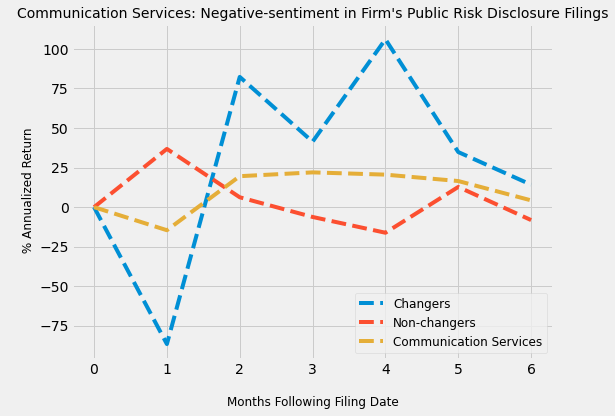

In [72]:
#Communication Services sector review
style.use('fivethirtyeight')

sector = 'Communication Services'
sectors = return_comp_windows[return_comp_windows['Sector'] == sector]  

fig,ax = plt.subplots(figsize=(8,6))

for type in ['Changers','Non-changers', sector]:
    ax.plot(sectors[sectors.Strategy==type].Months,
            sectors[sectors.Strategy==type].Ann_Returns,
            label=type, linestyle=('--'))

ax.set_xlabel("\nMonths Following Filing Date", fontsize= 12)
plt.ylabel("\n % Annualized Return",fontsize= 12)

ax.set_title("{}: Negative-sentiment in Firm's Public Risk Disclosure Filings".format(sector),fontsize=14)

ax.legend(loc='best',fontsize=12)

plt.show()

Lets review the poor performance of the Commmunication svcs sector by cycling through the subsectors to understand what created the imbalance.

In [ ]:
# tkr_by_year['GICS Sector'].unique()
tkr_by_year.rename(columns = {'GICS Sector':'GICS_Sector'}, inplace=True)
subsector = tkr_by_year.query("GICS_Sector =='Communication Services'")
# tkr_by_year.query("Ticker=='MMM'")
# tkr_by_year.columns

In [75]:
#Communication Services sector review

sector_returns_dict =  {'Months':[],'Sector':[],'Strategy':[],'Ann_Returns':[] }
year  = ['2015', '2016', '2017', '2018', '2019']
for term in range(1,210,30):
    print(term)
    #view portfolio returns by trading days within window per year for the basket
    daily = data.groupby(['Report_Period','Ticker']).head(term)
    tkr_by_year = daily[daily.Report_Period.isin(year)]
    tkr_by_year.rename(columns = {'GICS Sector':'GICS_Sector'}, inplace=True)
    tkr_by_year = tkr_by_year.query("GICS_Sector=='Communication Services'")
    for sector in tkr_by_year['GICS Sub Industry'].unique():
        
        sectors = tkr_by_year[tkr_by_year['GICS Sub Industry'] == sector]
        df1 = sectors.loc[(sectors['Cos_Sim'] < sectors['Cos_Sim'].quantile(0.25)) &
                    (sectors['Word_chg'] == 1)] #bottom quantile of CSim due to an increase in neg word frequency
        df2 = sectors.loc[(sectors['Cos_Sim'] > sectors['Cos_Sim'].quantile(0.75)) &
                    (sectors['Word_chg'] == -1)] #top quantile of CSim due to a small change in neg word frequency
    
#         market_sector = sectors['Adj_Close']
        sector_ret = CAGR(get_return(sectors, year))*100 #review the dispersion in the sectors at the 60day time window
        sector_returns_dict['Months'].append(math.floor(term/30))
        sector_returns_dict['Sector'].append(sector)
        sector_returns_dict['Strategy'].append(sector)
        sector_returns_dict['Ann_Returns'].append(sector_ret)
#         sector_returns_dict['Sharpe'].append(market_alpha_shp)
        
        change_ret = CAGR(get_return(df1, year))*100 #review the dispersion in the sectors at the 60day time window
        sector_returns_dict['Months'].append(math.floor(term/30))
        sector_returns_dict['Sector'].append(sector)
        sector_returns_dict['Strategy'].append("Changers")
        sector_returns_dict['Ann_Returns'].append(change_ret)
#         sector_returns_dict['Sharpe'].append(change_alpha_shp)
    
#         non_changers = df2['Return'] #all stocks in dataset, no filter

        nonchange_ret = CAGR(get_return(df2, year))*100 #review the dispersion in the sectors at the 60day time window
        
        sector_returns_dict['Months'].append(math.floor(term/30))
        sector_returns_dict['Sector'].append(sector)
        sector_returns_dict['Strategy'].append("Non-changers")
        sector_returns_dict['Ann_Returns'].append(nonchange_ret)
#         sector_returns_dict['Sharpe'].append(nonchange_shp)
    
sub_sector_windows = pd.DataFrame(sector_returns_dict)


1
31
61
91
121
151
181


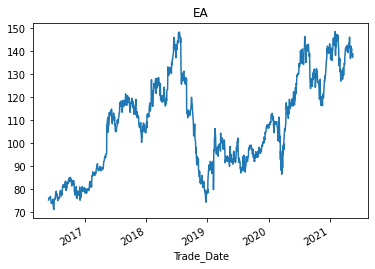

In [8]:

data_sectors = data.copy()
data_sectors.set_index('Trade_Date', inplace=True)
data_sectors.rename(columns={"GICS Sub Industry":"Subsector"}, inplace=True)
df1 = data_sectors.query("Subsector=='Interactive Home Entertainment'")
df1.Ticker.unique()
symbol = 'EA'
df1.query("Ticker==@symbol").Adj_Close.plot(title=symbol);


### Let's look through all the sectors to see which ones outperform and which do not work

In general, we'd expect the Market portfolio (complete universe of names) to exhibit a similar return profile with that of the Non-changers segment (no significant sentiment change YoY) or fall between the Non-changers and the Changers segment (increased \n negative sentiment in public filings.

While 80% of the sectors with negative word increases underperformed those sectors with firms' that had little change to its filings, Materials and Communiation Services displayed extremely abnormal returns.
    

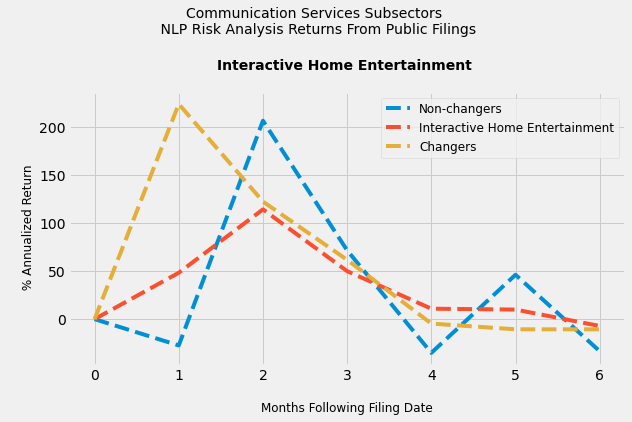

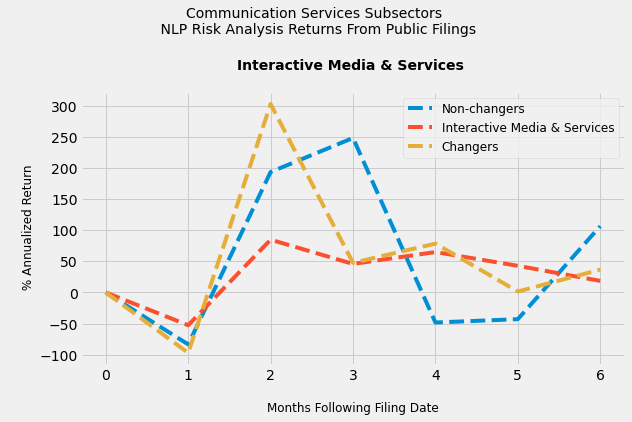

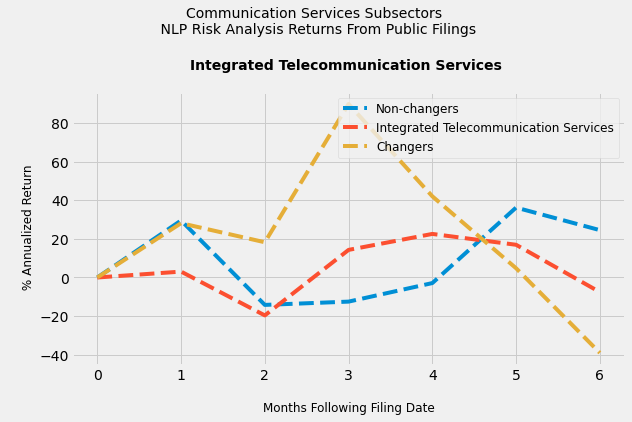

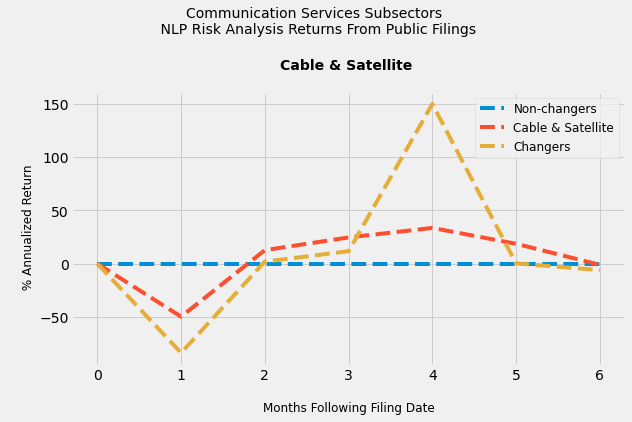

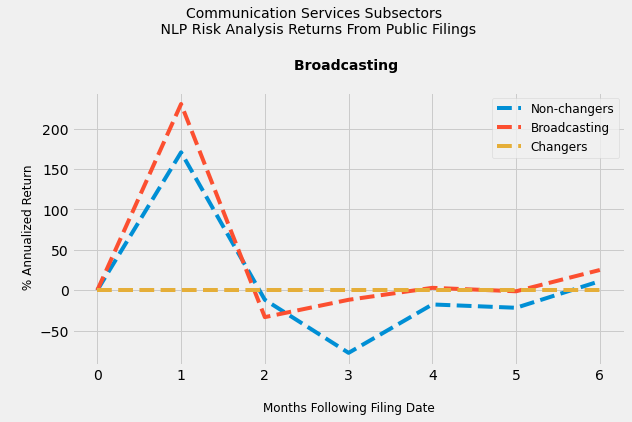

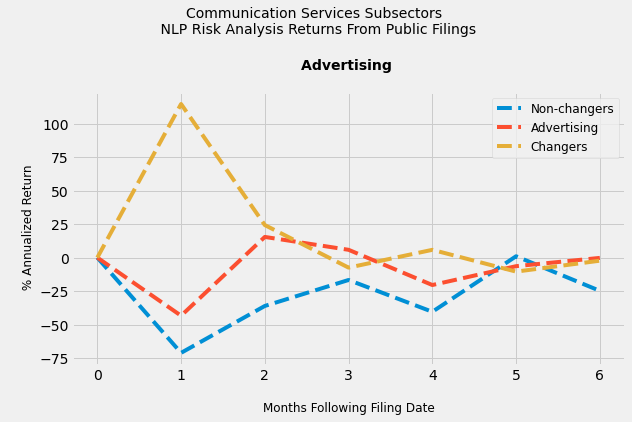

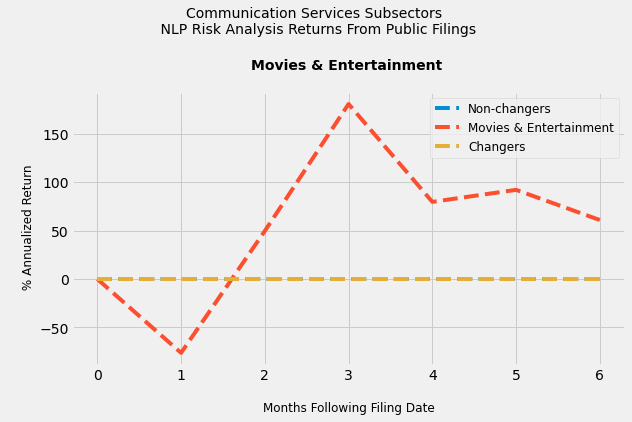

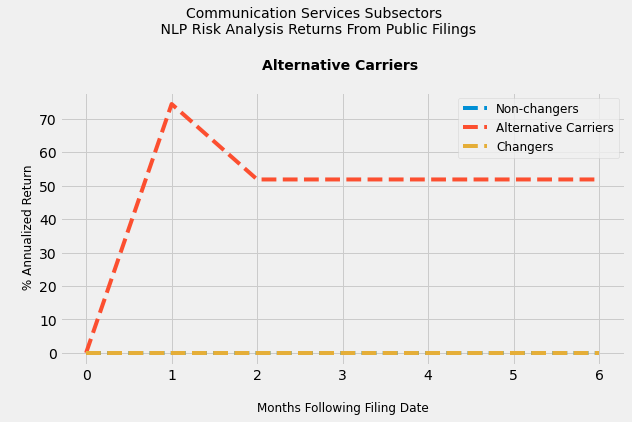

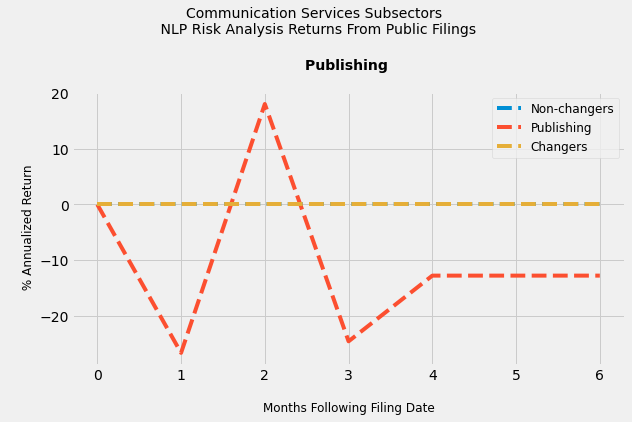

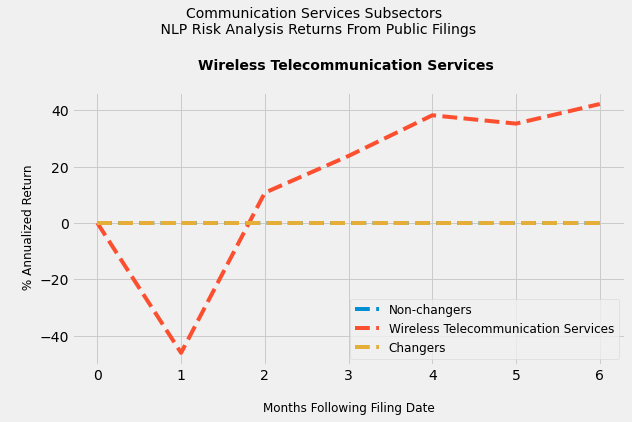

In [121]:
import matplotlib.pyplot as plt

    
for sector in sub_sector_windows['Sector'].unique():

    sectors = sub_sector_windows[sub_sector_windows['Sector'] == sector]  

    fig,ax = plt.subplots(figsize=(9,6))

    for type in ['Non-changers',sector,'Changers']:
        ax.plot(sectors[sectors.Strategy==type].Months,
                sectors[sectors.Strategy==type].Ann_Returns,
                label=type, linestyle=('--'))

    plt.suptitle("Communication Services Subsectors \n NLP Risk Analysis Returns From Public Filings",fontsize= 14)
    ax.set_title(f"{sector} \n", fontweight='bold',fontsize=14)
    ax.set_xlabel("\nMonths Following Filing Date", fontsize= 12)
    plt.ylabel("\n % Annualized Return",fontsize= 12)
    ax.legend(loc='best',fontsize= 12)

    
    
    plt.savefig("sub_sector_return_curves.png", dpi = 75)
    
    plt.show()

In [40]:
sector = 'Materials'
sectors = return_comp_windows[return_comp_windows['Sector'] == sector] 

sectors.head(9)

,Months,Sector,Strategy,Ann_Returns
21,0,Materials,Materials,0.000000
22,0,Materials,Changers,0.000000
23,0,Materials,Non-changers,0.000000
54,1,Materials,Materials,34.516429
55,1,Materials,Changers,-1.421247
56,1,Materials,Non-changers,34.441205
87,2,Materials,Materials,18.385628
88,2,Materials,Changers,34.661790
89,2,Materials,Non-changers,6.425748


In [41]:
sector_review.head(1)

,Ticker,Company,GICS Sector,GICS Sub Industry,Report_Period,Filing_Date,Cos_Sim,Word_chg,Date,Adj_Close
10326,APD,Air Products & Chemicals Inc,Materials,Industrial Gases,2019.0,2019-11-26,0.295201,1.0,2019-11-26,229.379


In [43]:
#Is there a year in which this data is most distorted?

sector = ['Materials']
# year  = [2018]

sector_review = daily[daily['GICS Sector'].isin(sector)]

# print(sector_review['Ticker'].nunique())
sector_review.groupby( 
    ['Report_Period']).agg(
     {  'Cos_Sim': "mean",
      'Word_chg': "min"

     }
    )

,Cos_Sim,Word_chg
Report_Period,,
2015.0,0.872789,-1.0
2016.0,0.912300,-1.0
2017.0,0.872476,-1.0
2018.0,0.889580,-1.0
2019.0,0.822893,-1.0


In [20]:
# #2020 seems to be a significant outlier however in general most years weren't great either

rpt_year  = [2019]

year_in_review = sector_review[sector_review.Report_Period.isin(rpt_year)]

year_in_review.Filing_Date.unique()

<PeriodArray>
['2019-11-26', '2020-04-15', '2020-02-26', '2020-02-19', '2020-02-06',
 '2020-02-24', '2020-02-28', '2020-02-14', '2020-03-03', '2020-02-20',
 '2020-02-21', '2020-03-02']
Length: 12, dtype: period[D]

In [21]:
#November is a strange time to be filing a 10K report 

year_in_review.head()
#That nov fiing was indeed an outlier, cos sim was indicates that filing was quite different than prior years 
#howeverthe stock performed ok.


,Ticker,Company,GICS Sector,GICS Sub Industry,Report_Period,Filing_Date,Cos_Sim,Word_chg,Date,Adj_Close,Year,Return
219346,APD,Air Products & Chemicals Inc,Materials,Industrial Gases,2019,2019-11-26,0.295201,1.0,2019-12-31,231.096,2019,0.003502
219347,APD,Air Products & Chemicals Inc,Materials,Industrial Gases,2019,2019-11-26,0.295201,1.0,2019-12-30,230.289,2019,-0.000679
219348,APD,Air Products & Chemicals Inc,Materials,Industrial Gases,2019,2019-11-26,0.295201,1.0,2019-12-27,230.446,2019,-0.002499
219349,APD,Air Products & Chemicals Inc,Materials,Industrial Gases,2019,2019-11-26,0.295201,1.0,2019-12-26,231.023,2019,0.004382
219350,APD,Air Products & Chemicals Inc,Materials,Industrial Gases,2019,2019-11-26,0.295201,1.0,2019-12-24,230.015,2019,-0.000383


In [22]:
tkr_mask = year_in_review['Ticker'] != 'APD' 
# year  = [2018]

tkr_review = year_in_review[tkr_mask]

tkr_review.groupby( 
    ['Year','Ticker']).agg(
     {  'Cos_Sim': "mean",
      'Word_chg': "min",
      'Return' :"sum",
     }
    )

Cos_Sim  Word_chg    Return
Year Ticker                              
2020 ALB     0.017148      -1.0  0.253630
     AVY     0.994736      -1.0  0.201628
     BLL     0.986218       1.0  0.232457
     CE      0.866969       1.0  0.226629
     CF      0.991064       1.0 -0.050424
     ECL     0.978758      -1.0  0.226670
     EMN     1.000000       0.0  0.416155
     FCX     0.973755       1.0  0.567102
     FMC     0.955837      -1.0  0.282359
     IFF     1.000000       1.0  0.064343
     IP      0.942906       1.0  0.159860
     LYB     0.997766       1.0  0.223023
     MLM     0.000000       1.0  0.225391
     NEM     0.986930       1.0  0.367940
     NUE     0.124681       1.0  0.300743
     PKG     0.887385       1.0  0.291340
     PPG     0.985866      -1.0  0.227252
     SEE     0.986305      -1.0  0.450024
     SHW     0.991443       1.0  0.287598
     VMC     0.988801      -1.0  0.348648

In [23]:
tkr_review.head()

,Ticker,Company,GICS Sector,GICS Sub Industry,Report_Period,Filing_Date,Cos_Sim,Word_chg,Date,Adj_Close,Year,Return
293331,ALB,Albemarle Corp,Materials,Specialty Chemicals,2019,2020-04-15,0.017148,-1.0,2020-10-09,96.03,2020,-0.009489
293333,ALB,Albemarle Corp,Materials,Specialty Chemicals,2019,2020-04-15,0.017148,-1.0,2020-10-08,96.95,2020,0.002689
293334,ALB,Albemarle Corp,Materials,Specialty Chemicals,2019,2020-04-15,0.017148,-1.0,2020-10-07,96.69,2020,0.031470
293337,ALB,Albemarle Corp,Materials,Specialty Chemicals,2019,2020-04-15,0.017148,-1.0,2020-10-06,93.74,2020,-0.010764
293338,ALB,Albemarle Corp,Materials,Specialty Chemicals,2019,2020-04-15,0.017148,-1.0,2020-10-05,94.76,2020,0.061261


In [25]:
#APD greatly increased its negative word frequency despite that the stock went up 27%??
tkr_review.Filing_Date.unique()
#they generally report in Nov, so that rules out something odd in 2020 filing date, but
#why did it increase so much?

<PeriodArray>
['2020-04-15', '2020-02-26', '2020-02-19', '2020-02-06', '2020-02-24',
 '2020-02-28', '2020-02-14', '2020-03-03', '2020-02-20', '2020-02-21',
 '2020-03-02']
Length: 11, dtype: period[D]